(a) (2 points) Implement the distinct words function in co occurrence.py. You can do this with for
loops, but it’s more efficient to do it with Python list comprehensions.

(b) (5 points) Implement the compute co occurrence function in co occurrence.py. If you aren’t
familiar with the python numpy package, we suggest walking yourself through this tutorial: http:
//cs231n.github.io/python-numpy-tutorial.

(c) (2 points) Implement the reduce to k dim function in co occurrence.py

In [28]:
import sys
import os
import numpy as np
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

import numpy as np
import matplotlib

import matplotlib.pyplot as plt

plt.style.use('classic')
plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
corpus = ["START All that glitters isn't gold END".split(" "), 
          "START All's well that ends well END".split(" "),
         "START All that that isn't glitters END".split(" "),]
corpus

[['START', 'All', 'that', 'glitters', "isn't", 'gold', 'END'],
 ['START', "All's", 'well', 'that', 'ends', 'well', 'END'],
 ['START', 'All', 'that', 'that', "isn't", 'glitters', 'END']]

In [3]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1

    ### SOLUTION BEGIN
    words = set()
    for doc in corpus:
        words.update([word for word in doc])

    corpus_words = sorted(words)
    num_corpus_words = len(words)
    ### SOLUTION END

    return corpus_words, num_corpus_words

In [4]:
words, num_words = distinct_words(corpus)
word2Ind = {}
for i, word in enumerate(words):
    word2Ind[word] = i
print(word2Ind)

{'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}


In [5]:
import nltk
nltk.download('reuters')
from nltk.corpus import reuters

START_TOKEN = '<START>'
END_TOKEN = '<END>'

def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


[nltk_data] Downloading package reuters to
[nltk_data]     /Users/yrybitskyi/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [6]:
reuters_corpus = read_corpus()

In [7]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurrence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}

    ### SOLUTION BEGIN

    for i, word in enumerate(words):
        word2Ind[word] = i

    def relu(x):
        if x > 0:
            return x
        else:
            return 0

    max_doc_length = 0
    for doc in corpus:
        doc_length = len(doc)
        if doc_length > max_doc_length:
            max_doc_length = doc_length


    corpus_index = np.zeros((len(corpus), max_doc_length))
    skipped_words = set()
    for i, doc in enumerate(corpus):
        for j, word in enumerate(doc):
            w_idx = word2Ind.get(word)
            if w_idx is not None:
                corpus_index[i, j] = w_idx
            else:
                skipped_words.add(word)

    print(f"skipped_words : {sorted(skipped_words)}")

    print(f"corpus_index.shape: {corpus_index.shape}")

    def word_context(doc_index, word_index, wd_size):
        word_context_map = {}

        doc = corpus_index[doc_index]
        left_context = doc[relu(word_index - wd_size) : word_index]
        right_context = doc[word_index + 1 : word_index + wd_size + 1]

        for w in left_context:
            cnt = word_context_map.get(w, 0)
            word_context_map[w] = cnt + 1
        for w in right_context:
            cnt = word_context_map.get(w, 0)
            word_context_map[w] = cnt + 1

        return word_context_map

    M = np.empty((num_words, num_words))
    M[:] = np.nan

    # Cache all words in corpus
    # word_presence = [None] * num_words
    word_presence = []
    for i in range(num_words):
        # word_presence[i] = np.array(np.where(corpus_index == i)).T
        rows, cols = np.where(corpus_index == i)
        doc_wordpos_map = {}

        for t in zip(rows, cols):
            doc_idx = t[0]
            word_position = t[1]
            word_index = doc_wordpos_map.get(doc_idx)
            if word_index is None:
                word_index = set()
            word_index.add(word_position)
            doc_wordpos_map[doc_idx] = word_index

        word_presence.append(doc_wordpos_map)

    print(f"len(word_presence): {len(word_presence)}")

    for i in range(num_words):
        # print(f"{i} from {num_words}")
        i_doc_wordpos_map = word_presence[i]
        i_doc_indexes = i_doc_wordpos_map.keys()

        for j in range(num_words):
            if i == j:
                M[i, j] = 0
                continue
            if np.isnan(M[j, i]):
                j_doc_wordpos_map = word_presence[j]
                cnt = 0
                for j_doc_idx in j_doc_wordpos_map.keys():

                    if j_doc_idx in i_doc_indexes:
                        for wi in j_doc_wordpos_map[j_doc_idx]:
                            word_context_map = word_context(j_doc_idx, wi, window_size)
                            cnt = cnt + word_context_map.get(i, 0)

                M[i, j] = cnt
            else:
                M[i, j] = M[j, i]

### SOLUTION END

    return M, word2Ind

In [8]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurrence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of number of corpus words)): co-occurrence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    np.random.seed(4355)
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    ### SOLUTION BEGIN
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    ### SOLUTION END

    print("Done.")
    return M_reduced

In [9]:
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus[:10])
cnt = np.count_nonzero(M_co_occurrence > 0)
if np.count_nonzero(M_co_occurrence > 0) == 0:
    raise Exception("Matrix's empty")
print(f"Result Matrix Count: {cnt}")

skipped_words : []
corpus_index.shape: (10, 1001)
len(word_presence): 888
Result Matrix Count: 15704


In [10]:
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
print(M_reduced_co_occurrence.size)

Running Truncated SVD over 888 words...
Done.
1776


In [11]:
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

In [24]:
def plot_embeddings(M_reduced, word2Ind, words, title):
    plt.clf()
    fig = plt.figure()
    fig.suptitle(title, fontsize=20)
    for word in words:
        idx = word2Ind[word]
        x = M_reduced[idx, 0]
        y = M_reduced[idx, 1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    

<Figure size 800x400 with 0 Axes>

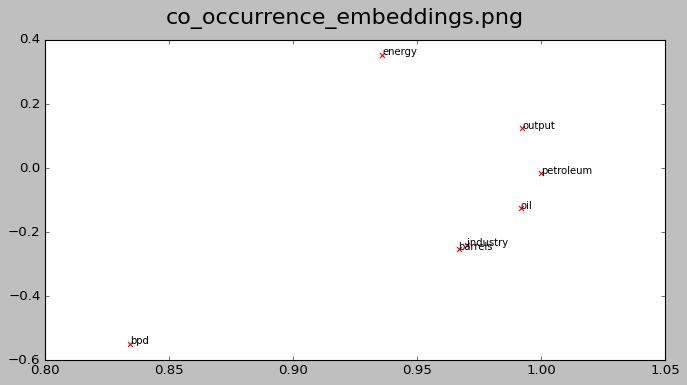

In [26]:
# words_list = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
words_list = ['barrels', 'bpd', 'energy', 'industry', 'oil', 'output', 'petroleum']

plot_embeddings(M_normalized, word2Ind_co_occurrence, words_list, 'co_occurrence_embeddings.png')